## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0719 11:59:52.234344 13176 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:92: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0719 11:59:52.238296 13176 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0719 11:59:52.336424 13176 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:99: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 11:59:52.337421 13176 deprecation_wrapper.py:119] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 11:59:52.372862 131

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0719 11:59:52.571329 13176 deprecation.py:323] From C:\Users\KCB-SA\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 172us/step - loss: 15.1103 - acc: 0.2674 - val_loss: 13.9814 - val_acc: 0.3316
Epoch 2/50
50000/50000 [==============================] - 8s 167us/step - loss: 13.0469 - acc: 0.3510 - val_loss: 12.1506 - val_acc: 0.3662
Epoch 3/50
50000/50000 [==============================] - 8s 169us/step - loss: 11.3699 - acc: 0.3768 - val_loss: 10.6177 - val_acc: 0.3841
Epoch 4/50
50000/50000 [==============================] - 8s 153us/step - loss: 9.9536 - acc: 0.3937 - val_loss: 9.3161 - val_acc: 0.3984
Epoch 5/50
50000/50000 [==============================] - 7s 149us/step - loss: 8.7515 - acc: 0.4026 - val_loss: 8.2098 - val_acc: 0.4033
Epoch 6/50
50000/50000 [==============================] - 8s 153us/step - loss: 7.7272 - acc: 0.4090 - val_loss: 7.2697 - val_acc: 0.4076
Epoch 7/50
50000/50000 [==============================] - 8s 161us/step - loss: 6.8556 - acc: 0.4158 - val_loss: 6.4

50000/50000 [==============================] - 9s 173us/step - loss: 2.1691 - acc: 0.2775 - val_loss: 2.0032 - val_acc: 0.3477
Epoch 2/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.9451 - acc: 0.3648 - val_loss: 1.9012 - val_acc: 0.3774
Epoch 3/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.8610 - acc: 0.3970 - val_loss: 1.8268 - val_acc: 0.4036
Epoch 4/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.8032 - acc: 0.4172 - val_loss: 1.7907 - val_acc: 0.4128
Epoch 5/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7576 - acc: 0.4318 - val_loss: 1.7453 - val_acc: 0.4345
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.7183 - acc: 0.4449 - val_loss: 1.7221 - val_acc: 0.4424
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.6858 - acc: 0.4565 - val_loss: 1.6886 - val_acc: 0.4518
Epoch 8/50
50000/50000 [====================

50000/50000 [==============================] - 8s 157us/step - loss: 1.8044 - acc: 0.3664 - val_loss: 1.7558 - val_acc: 0.3860
Epoch 3/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.7191 - acc: 0.3998 - val_loss: 1.6981 - val_acc: 0.4057
Epoch 4/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.6614 - acc: 0.4169 - val_loss: 1.6346 - val_acc: 0.4321
Epoch 5/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.6132 - acc: 0.4343 - val_loss: 1.5967 - val_acc: 0.4404
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.5756 - acc: 0.4473 - val_loss: 1.5880 - val_acc: 0.4394
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.5425 - acc: 0.4590 - val_loss: 1.5594 - val_acc: 0.4511
Epoch 8/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.5137 - acc: 0.4688 - val_loss: 1.5283 - val_acc: 0.4581
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 143us/step - loss: 1.7122 - acc: 0.3991 - val_loss: 1.6740 - val_acc: 0.4179
Epoch 4/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6528 - acc: 0.4213 - val_loss: 1.6306 - val_acc: 0.4248
Epoch 5/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.6038 - acc: 0.4355 - val_loss: 1.5938 - val_acc: 0.4372
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5646 - acc: 0.4504 - val_loss: 1.5591 - val_acc: 0.4446
Epoch 7/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.5328 - acc: 0.4598 - val_loss: 1.5320 - val_acc: 0.4623
Epoch 8/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5020 - acc: 0.4733 - val_loss: 1.5286 - val_acc: 0.4549
Epoch 9/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.4758 - acc: 0.4820 - val_loss: 1.5022 - val_acc: 0.4697
Epoch 10/50
50000/50000 [====================

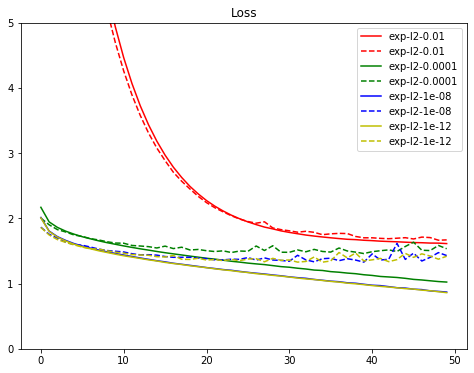

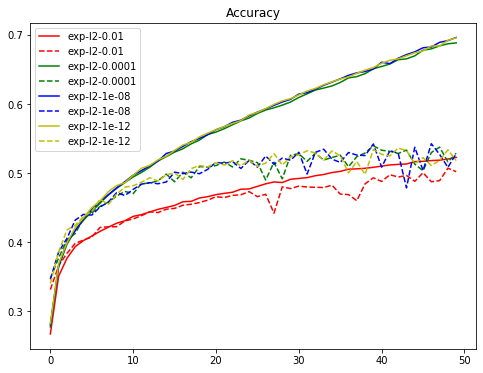

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()